## Софья Скобелева
## Домашнее задание
## 1. Постановка задачи

Вам предстоит решить настоящую задачу машинного обучения, направленную на автоматизацию бизнес процессов. Мы построим модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке. 

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для вас как для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели задания:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных


## 2. Знакомство с данными, базовый анализ и расширение данных (10 баллов)

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет. 


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

Прочитаем наш файл с исходными данными:

In [40]:
taxi_data = pd.read_csv("train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

Мы условно разделили признаки нескольких групп. 


**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 

### Задание 2.1 (1 балл)
Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведите признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S'). 

Определите временные рамки (без учета времени), за которые представлены данные.

In [41]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')

In [42]:
mindate = taxi_data['pickup_datetime'].min().date()
maxdate = taxi_data['pickup_datetime'].max().date()
print("Минимальная дата:", mindate)
print("Максимальная дата:", maxdate)

Минимальная дата: 2016-01-01
Максимальная дата: 2016-06-30


Временные рамки с 1 января по 30 июня 2016 года

### Задание 2.2 (1 балл)
Посмотрим на пропуски. 
Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)?

In [43]:
taxi_data.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

Пропусков нет!

### Задание 2.3 (1 балл)
Посмотрим на статистические характеристики некоторых признаков. 

а) Сколько уникальных таксопарков присутствует в данных?

In [44]:
taxi_data['vendor_id'].nunique()

2

б) Каково максимальное количество пассажиров?

In [45]:
taxi_data['passenger_count'].max()

9

в) Чему равна средняя и медианная длительность поездки? Ответ приведите в секундах и округлите до целого.

In [46]:
round(taxi_data['trip_duration'].mean())

959

In [47]:
round(taxi_data['trip_duration'].median())

662

г) Чему равно минимальное и максимальное время поездки (в секундах)?

In [48]:
taxi_data['trip_duration'].min()

1

In [49]:
taxi_data['trip_duration'].max()

3526282

### Задание 2.4 (2 балла)
Реализуйте функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - наименование дня недели, в который был включен счетчик.

Добавьте эти три столбца.

In [50]:
def add_datetime_features(df):
    df['pickup_date'] = df['pickup_datetime'].dt.date
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day_of_week'] = df['pickup_datetime'].dt.day_name()
    return df

taxi_data = add_datetime_features(taxi_data)
taxi_data

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,Monday
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,Sunday
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,Tuesday
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,Wednesday
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,2016-04-08,13,Friday
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,2016-01-10,7,Sunday
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,2016-04-22,6,Friday
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,2016-01-05,15,Tuesday


а) Сколько поездок было совершено в субботу?

In [51]:
(taxi_data['pickup_day_of_week'] == 'Saturday').sum()

220868

б) Сколько поездок в среднем совершается в день? 

In [52]:
taxi_data['pickup_date'].count()/taxi_data['pickup_date'].nunique() 

8014.527472527472

In [53]:
trips_per_day = taxi_data.groupby('pickup_day_of_week').size() / taxi_data['pickup_day_of_week'].nunique()

print("Среднее количество поездок в каждый день недели:")
print(trips_per_day)

Среднее количество поездок в каждый день недели:
pickup_day_of_week
Friday       31933.285714
Monday       26774.000000
Saturday     31552.571429
Sunday       27909.428571
Thursday     31224.857143
Tuesday      28964.142857
Wednesday    30019.428571
dtype: float64


### Задание 2.5 (2.5 балла)

Теперь, когда мы разобрались с временными характеристиками, переходим к географическим.

В данных есть столбцы, содержащие информацию о широте и долготе. Из них можно извлечь очень много полезной информации.

Например, зная широту и долготу начальной и конечной точек маршрута, мы можем воспользоваться OSRM API.

OSRM (Open Source Routing Machine) — это открытый бесплатный ресурс, который активно используется во многих сервисах, предполагающих построение кратчайшего маршрута. Он позволяет построить оптимальный кусочно-линейный путь из точки А в точку B, а также узнать его примерную длительность и длину. 

Проблема заключается в том, что, так как в наших данных содержится информация о более чем одном миллионе поездок, подгрузка данных с помощью API и их предобработка может занять несколько часов, а при слабом интернет-соединении — и дней. Поэтому мы заранее подготовили выгрузку данных из OSRM API для каждой поездки из выборки нашего набора данных.

Файлы с данными из OSRM для поездок из тренировочной таблицы вы можете найти во втором файле. Наборы данных представлены в табличном формате CSV. Нас будут интересовать только следующие столбцы:

* id — идентификатор поездки;
* total_distance — кратчайшее дорожное расстояние (в метрах) из точки, в которой был включён счётчик, до точки, в которой счётчик был выключен (согласно OSRM);
* total_travel_time — наименьшее время поездки (в секундах) из точки, в которой был включён счётчик, до точки, в которой счётчик был выключен (согласно OSRM);
* number_of_steps — количество дискретных шагов, которые должен выполнить водитель (поворот налево/поворот направо/ехать прямо и т. д.).

Реализуйте функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

In [54]:
osrm = pd.read_csv("osrm_data_train.csv")
osrm

,id,starting_street,end_street,total_distance,total_travel_time,number_of_steps,street_for_each_step,distance_per_step,travel_time_per_step,step_maneuvers,step_direction,step_location_list
0,id2875421,Columbus Circle,East 65th Street,2009.1,164.9,5,Columbus Circle|Central Park West|65th Street ...,0|576.4|885.6|547.1|0,0|61.1|60.1|43.7|0,depart|rotary|turn|new name|arrive,left|straight|right|straight|arrive,"-73.982316,40.767869|-73.981997,40.767688|-73...."
1,id2377394,2nd Avenue,Washington Square West,2513.2,332.0,6,2nd Avenue|East 13th Street|5th Avenue|Washing...,877.3|836.5|496.1|164.2|139.1|0,111.7|109|69.9|25.8|15.6|0,depart|turn|turn|end of road|continue|arrive,none|right|left|right|left|arrive,"-73.980429,40.73857|-73.985444,40.731658|-73.9..."
2,id3504673,Greenwich Street,Broadway,1779.4,235.8,4,Greenwich Street|Park Place|Broadway|Broadway,644.2|379.9|755.3|0,80.5|50.8|104.5|0,depart|turn|end of road|arrive,left|left|right|arrive,"-74.010145,40.719982|-74.011527,40.714294|-74...."
3,id2181028,Broadway,West 81st Street,1614.9,140.1,5,Broadway|West 86th Street|Columbus Avenue|West...,617|427.4|412.2|158.3|0,56|36|37.8|10.3|0,depart|turn|turn|turn|arrive,right|left|right|left|arrive,"-73.972998,40.793187|-73.976607,40.788361|-73...."
4,id0801584,Lexington Avenue,West 31st Street,1393.5,189.4,5,Lexington Avenue|East 27th Street|Madison Aven...,18.9|311.9|313.3|749.4|0,6.3|42.9|48.4|91.8|0,depart|turn|turn|turn|arrive,right|right|right|left|arrive,"-73.982805,40.742173|-73.982914,40.742024|-73...."
...,...,...,...,...,...,...,...,...,...,...,...,...
1458638,id2976426,Cargo Plaza,East 51st Street,28051.1,1462.5,13,Cargo Plaza|Cargo Plaza|Van Wyck Expressway|Ca...,145.4|1039|12154.4|931.8|6422.3|3745.6|2032.5|...,21|82.8|489.4|57.2|359.5|164.1|139.9|14.4|2.9|...,depart|on ramp|new name|off ramp|merge|fork|ne...,right|slight right|straight|slight right|sligh...,"-73.78445,40.648461|-73.785844,40.647851|-73.7..."
1458639,id1440046,Former Terminal 6 Departures,3rd Avenue,29616.3,1643.2,16,Former Terminal 6 Departures|Cargo Plaza|Cargo...,110.2|415.2|895.1|12154.4|931.8|6422.3|1686.5|...,15.9|63.9|71.6|489.4|57.2|359.5|81.8|19.4|10.3...,depart|fork|on ramp|new name|off ramp|merge|fo...,right|slight left|straight|straight|slight rig...,"-73.779336,40.647005|-73.780349,40.64763|-73.7..."
1458640,id1607338,Cargo Plaza,West 8th Street,25615.0,1765.1,30,Cargo Plaza|Cargo Plaza|Cargo Plaza|Cargo Plaz...,179.5|66.3|314.8|431.8|1557.5|266.3|454.7|604|...,28|9.5|25.2|34.5|62|21.3|36.6|24.1|25.2|238.2|...,depart|fork|on ramp|fork|new name|off ramp|for...,none|slight right|straight|slight left|straigh...,"-73.786697,40.641627|-73.78622,40.643052|-73.7..."
1458641,id2071901,Cargo Plaza,Laurel Hill Boulevard,20284.1,1074.3,14,Cargo Plaza|Cargo Plaza|Cargo Plaza|Van Wyck E...,124.3|535.2|895.1|12154.4|931.8|1521.6|573.1|3...,22|79|71.6|489.4|57.2|85.4|45.9|28.5|22.2|9.5|...,depart|fork|fork|new name|off ramp|merge|off r...,right|straight|slight left|straight|slight rig...,"-73.782317,40.644873|-73.780877,40.645095|-73...."


In [55]:
def add_osrm_features(trips, osrm):
    trips['total_distance'] = osrm['total_distance']
    trips['total_travel_time'] = osrm['total_travel_time']
    trips['number_of_steps'] = osrm['number_of_steps']
    return trips

add_osrm_features(taxi_data, osrm)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,total_distance,total_travel_time,number_of_steps
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,Monday,2009.1,164.9,5.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,Sunday,2513.2,332.0,6.0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,Tuesday,1779.4,235.8,4.0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,Wednesday,1614.9,140.1,5.0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,Saturday,1393.5,189.4,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,2016-04-08,13,Friday,29616.3,1643.2,16.0
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,2016-01-10,7,Sunday,25615.0,1765.1,30.0
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,2016-04-22,6,Friday,20284.1,1074.3,14.0
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,2016-01-05,15,Tuesday,30302.5,1675.8,20.0


а) Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM? 

В результате объединения таблиц у вас должны были получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника. 

In [56]:
median_df = taxi_data['trip_duration'].median()
median_df

662.0

In [57]:
median_osrm = osrm['total_travel_time'].median()
median_osrm 

289.5

In [58]:
median_df - median_osrm 

372.5

б) Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?

In [59]:
taxi_data.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
pickup_date           0
pickup_hour           0
pickup_day_of_week    0
total_distance        1
total_travel_time     1
number_of_steps       1
dtype: int64

После объединения таблиц в каждом столбце с информацией из OSRM API содержится по одному пропуску

### Задание 2.6 (2.5 балла)

В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найти слишком продолжительные поездки. Давайте условимся, что ___выбросами будут считаться поездки, длительность которых превышает 24 часа.___ 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить ___среднюю скорость автомобиля на кратчайшем пути___ следующим образом: 
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет ___300 км/ч.___

Найдите поездки, длительность которых превышает 24 часа. И удалите их из набора данных.

а) Сколько выбросов по признаку длительности поездки вам удалось найти?

In [60]:
dur_up_outliers = taxi_data[taxi_data['trip_duration'] > 24*60*60]
dur_up_outliers

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,total_distance,total_travel_time,number_of_steps
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,1939736,2016-01-05,0,Tuesday,0.0,0.0,2.0
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,2049578,2016-02-13,22,Saturday,2175.4,199.5,7.0
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,2227612,2016-01-05,6,Tuesday,1945.4,161.8,5.0
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,3526282,2016-02-13,22,Saturday,2012.2,176.0,5.0


По признаку длительности поездки нам удалось найти 4 выброса, которые превышают 24 часа. Удалим их из набора данных

In [61]:
taxi_data = taxi_data[taxi_data['trip_duration'] <= 24*60*60]
taxi_data.shape

(1458640, 17)

Найдите поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалите их из данных.  
б) Сколько выбросов по признаку скорости вам удалось найти?

In [62]:
taxi_data['avg_speed'] = taxi_data['total_distance']*3600/(1000 * taxi_data['trip_duration'])
taxi_data

/var/folders/2z/bf5mgy7j5pb1867dmyny89780000gn/T/ipykernel_42871/2440631619.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxi_data['avg_speed'] = taxi_data['total_distance']*3600/(1000 * taxi_data['trip_duration'])


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,total_distance,total_travel_time,number_of_steps,avg_speed
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,Monday,2009.1,164.9,5.0,15.896176
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,Sunday,2513.2,332.0,6.0,13.646335
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,Tuesday,1779.4,235.8,4.0,3.015932
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,Wednesday,1614.9,140.1,5.0,13.551608
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,Saturday,1393.5,189.4,5.0,11.532414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,2016-04-08,13,Friday,29616.3,1643.2,16.0,137.042005
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,2016-01-10,7,Sunday,25615.0,1765.1,30.0,140.784733
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,2016-04-22,6,Friday,20284.1,1074.3,14.0,95.579529
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,2016-01-05,15,Tuesday,30302.5,1675.8,20.0,292.463807


In [63]:
speed_outliers = taxi_data[taxi_data['avg_speed'] > 300]
speed_outliers

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,total_distance,total_travel_time,number_of_steps,avg_speed
321,id3013319,2,2016-02-15 22:28:54,2016-02-15 22:30:27,1,-73.981400,40.778793,-73.976524,40.782497,N,93,2016-02-15,22,Monday,8504.2,583.0,6.0,329.194839
571,id1001293,1,2016-05-07 01:40:15,2016-05-07 01:41:39,1,-73.977753,40.745739,-73.981064,40.747047,N,84,2016-05-07,1,Saturday,7026.8,806.2,13.0,301.148571
842,id3263580,2,2016-05-21 12:46:46,2016-05-21 12:46:49,2,-73.782372,40.648766,-73.782372,40.648746,N,3,2016-05-21,12,Saturday,8081.3,743.2,8.0,9697.560000
1107,id0729156,2,2016-06-23 13:36:48,2016-06-23 13:36:50,3,-73.827660,40.716175,-73.822113,40.711452,N,2,2016-06-23,13,Thursday,1588.6,212.0,3.0,2859.480000
1492,id2456838,1,2016-01-13 20:11:46,2016-01-13 20:11:53,1,-73.793442,40.644814,-73.795242,40.644669,N,7,2016-01-13,20,Wednesday,1372.2,148.9,5.0,705.702857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458610,id1156695,2,2016-02-27 01:37:32,2016-02-27 01:40:39,1,-73.986832,40.733181,-73.986168,40.726452,N,187,2016-02-27,1,Saturday,27711.5,1475.3,14.0,533.483422
1458617,id0820021,2,2016-04-15 08:31:20,2016-04-15 08:34:48,1,-73.975433,40.752411,-73.973122,40.746780,N,208,2016-04-15,8,Friday,27296.9,1402.4,15.0,472.446346
1458624,id3482902,1,2016-03-01 07:21:04,2016-03-01 07:23:36,1,-73.974693,40.756088,-73.969971,40.762115,N,152,2016-03-01,7,Tuesday,29384.5,1566.4,16.0,695.948684
1458626,id0155863,2,2016-01-17 17:21:11,2016-01-17 17:25:15,2,-73.954071,40.767021,-73.950340,40.778233,N,244,2016-01-17,17,Sunday,29180.3,1614.8,17.0,430.529016


По признаку скорости нам удалось найти 17905 выбросов, которые превышают 300 км/ч. Удалим их из набора данных

In [64]:
taxi_data = taxi_data[taxi_data['avg_speed'] <= 300]
taxi_data.shape
(1458640, 18)

(1458640, 18)

## 3. Разведывательный анализ данных (EDA) (6 баллов)

Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [65]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

/var/folders/2z/bf5mgy7j5pb1867dmyny89780000gn/T/ipykernel_42871/2786152232.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)


### Задание 3.1. (2 балла)
Постройте две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

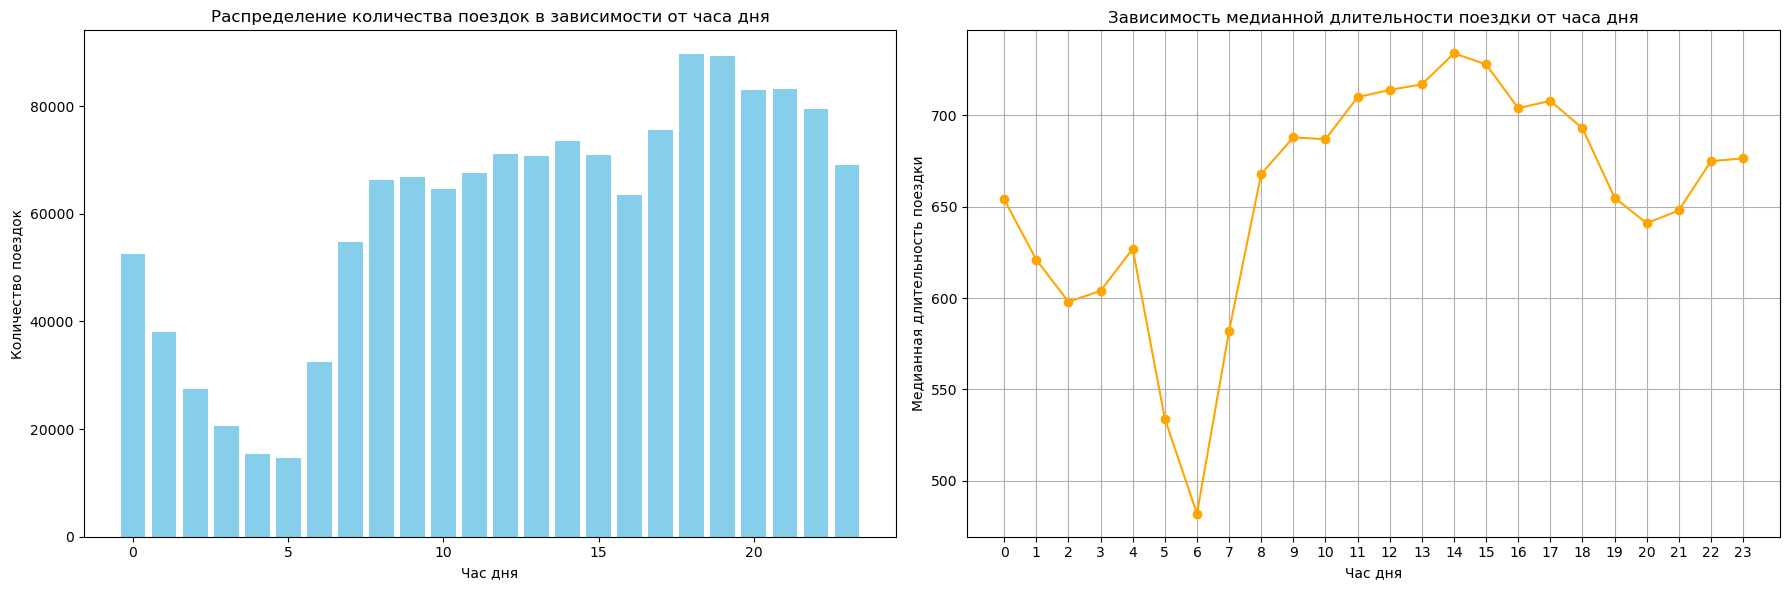

In [66]:
pickup_hour = taxi_data.groupby('pickup_hour').size()

plt.figure(figsize=(18,6))

plt.subplot(1, 2, 1)
plt.bar(pickup_hour.index, pickup_hour.values, color='skyblue')
plt.xlabel('Час дня')
plt.ylabel('Количество поездок')
plt.title('Распределение количества поездок в зависимости от часа дня')


median_trip_dur_hour = taxi_data.groupby('pickup_hour')['trip_duration'].median()
plt.subplot(1, 2, 2)
plt.plot(median_trip_dur_hour.index, median_trip_dur_hour.values, marker='o', color='orange')
plt.xlabel('Час дня')
plt.ylabel('Медианная длительность поездки')
plt.title('Зависимость медианной длительности поездки от часа дня')
plt.grid(True)
plt.xticks(np.arange(24)) 

plt.tight_layout()
plt.show()

__а) В какое время суток такси заказывают реже всего?__

Реже всего такси заказывают ночью (с двух часов ночи до пяти утра, реже всего -  в пять утра)

__б) В какое время суток наблюдается пик медианной длительности поездок?__

Пик медианной длительности поездок наблюдался в 14 часов дня

### Задание 3.2. (2 балла)
Постройте две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

Поставим дни недели в правильном порядке для того, чтобы было удобнее интерпретировать результаты:

In [67]:
from pandas.api.types import CategoricalDtype

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

taxi_data['pickup_day_of_week'] = taxi_data['pickup_day_of_week'].astype(CategoricalDtype(categories=day_order, ordered=True))

/var/folders/2z/bf5mgy7j5pb1867dmyny89780000gn/T/ipykernel_42871/1875818016.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxi_data['pickup_day_of_week'] = taxi_data['pickup_day_of_week'].astype(CategoricalDtype(categories=day_order, ordered=True))


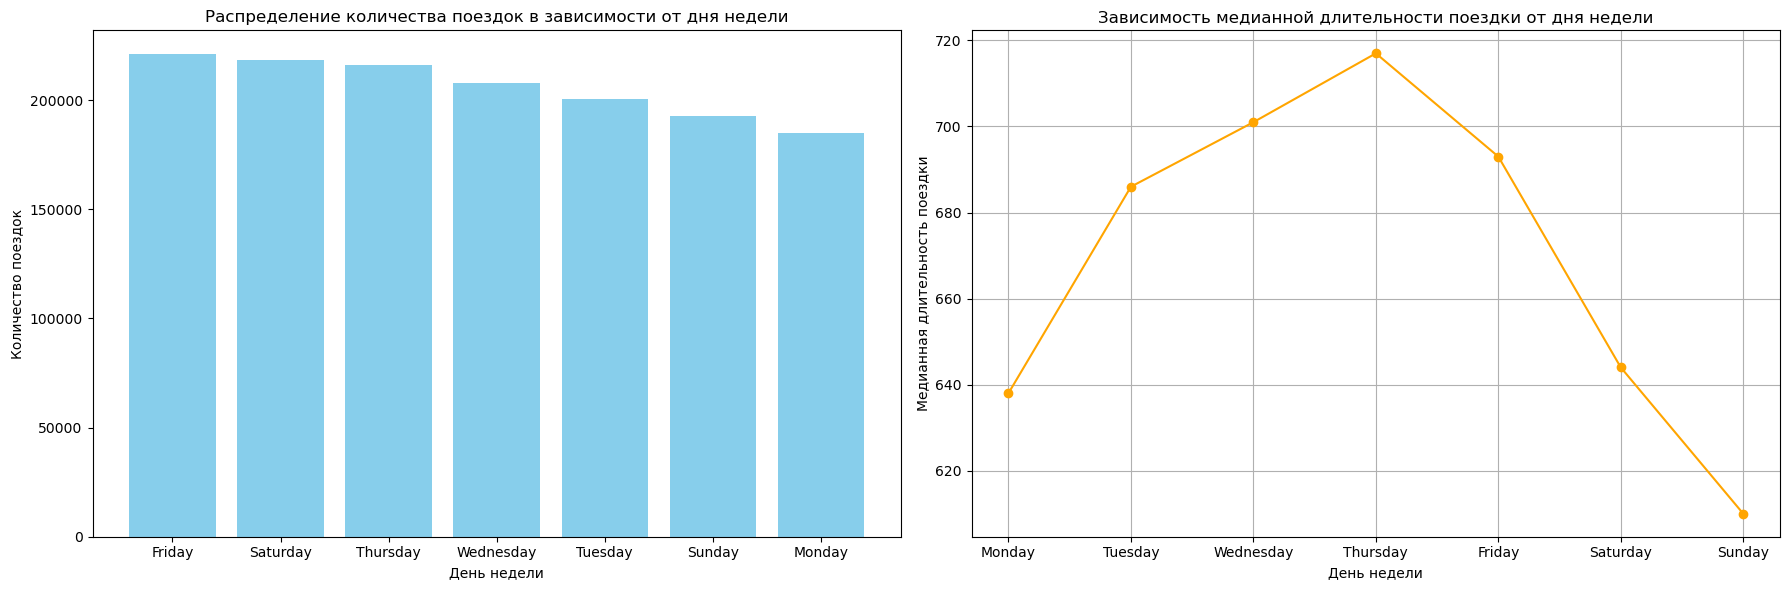

In [68]:
pickup_day_of_week = taxi_data['pickup_day_of_week'].value_counts()

plt.figure(figsize=(18,6))

plt.subplot(1, 2, 1)
plt.bar(pickup_day_of_week.index, pickup_day_of_week.values, color='skyblue')
plt.xlabel('День недели')
plt.ylabel('Количество поездок')
plt.title('Распределение количества поездок в зависимости от дня недели')



median_trip_dur_day = taxi_data.groupby('pickup_day_of_week')['trip_duration'].median()

plt.subplot(1, 2, 2)
plt.plot(median_trip_dur_day.index, median_trip_dur_day.values, marker='o', color='orange')
plt.xlabel('День недели')
plt.ylabel('Медианная длительность поездки')
plt.title('Зависимость медианной длительности поездки от дня недели')
plt.grid(True)

plt.tight_layout()
plt.show()

__а) В какой день недели совершается больше всего поездок?__

Больше всего поездок совершается в пятницу

__б) В какой день недели медианная длительность поездок наименьшая?__

Медианная длительность поездок наименьшая в воскресенье

### Задание 3.3. (2 балла)
Посмотрим на обе временные характеристики одновременно. 

Постройте сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration). 

Визуализируйте полученную сводную таблицу с помощью тепловой карты

In [69]:
table = taxi_data.pivot_table(index='pickup_hour', columns='pickup_day_of_week', 
                              values='trip_duration', aggfunc='median')
table

pickup_day_of_week,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
pickup_hour,,,,,,,
0,607.5,601.0,611.0,619.0,658.0,692.0,680.5
1,582.0,593.0,558.0,577.0,612.0,647.0,648.0
2,573.0,574.0,549.0,587.0,582.0,616.0,613.0
3,610.0,583.5,583.0,598.0,587.0,602.0,614.0
4,665.5,611.0,638.0,618.0,644.0,627.0,609.0
5,534.0,466.5,459.0,495.0,545.5,644.0,648.0
6,472.0,469.0,470.0,478.0,484.0,526.0,571.0
7,582.0,592.0,599.0,606.0,585.0,491.0,486.0
8,679.0,709.0,710.0,729.0,695.0,497.0,469.0


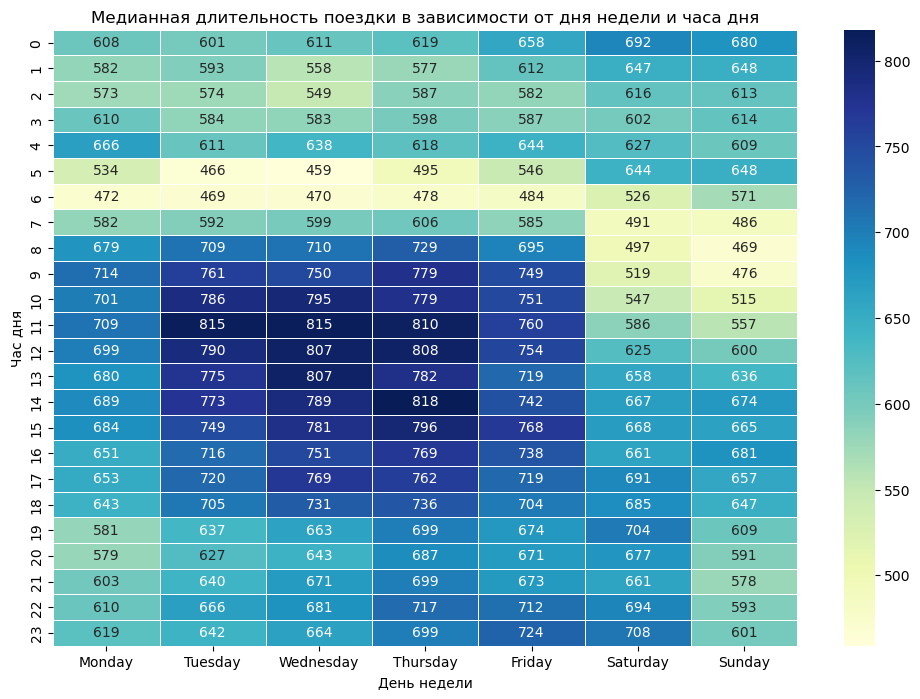

In [70]:
plt.figure(figsize=(12, 8))
sns.heatmap(table, cmap='YlGnBu', annot=True, fmt=".0f", linewidths=0.5)
plt.title('Медианная длительность поездки в зависимости от дня недели и часа дня')
plt.xlabel('День недели')
plt.ylabel('Час дня')
plt.show()

## 4. Отбор и преобразование признаков (4 балла)

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


### Задание 4.1. (1 балл)
Сразу позаботимся об очевидных неинформативных и избыточных признаках. 

а) Какой из признаков является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности?

б) Исключите выбранный признак из исходной таблицы с данными. 

Уникальным для каждой поездки является признак `id`. Он не несет полезной информации в определении ее продолжительности, уберем его

In [71]:
taxi_data = taxi_data.drop('id', axis = 1)

In [72]:
taxi_data

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,total_distance,total_travel_time,number_of_steps,avg_speed,trip_duration_log
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,Monday,2009.1,164.9,5.0,15.896176,6.122493
1,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,Sunday,2513.2,332.0,6.0,13.646335,6.498282
2,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,Tuesday,1779.4,235.8,4.0,3.015932,7.661527
3,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,Wednesday,1614.9,140.1,5.0,13.551608,6.063785
4,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,Saturday,1393.5,189.4,5.0,11.532414,6.077642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458638,2,2016-02-02 00:39:39,2016-02-02 00:46:33,5,-73.988823,40.736553,-73.989166,40.757393,N,414,2016-02-02,0,Tuesday,28051.1,1462.5,13.0,243.922609,6.028279
1458639,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,2016-04-08,13,Friday,29616.3,1643.2,16.0,137.042005,6.658011
1458640,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,2016-01-10,7,Sunday,25615.0,1765.1,30.0,140.784733,6.486161
1458641,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,2016-04-22,6,Friday,20284.1,1074.3,14.0,95.579529,6.639876


Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [73]:
drop_columns = ['pickup_datetime', 'pickup_date', 'dropoff_datetime']
taxi_data = taxi_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(taxi_data.shape))

Shape of data:  (1440734, 15)


### Задание 4.2. (1.5 балла)
Закодируйте признак vendor_id в таблице train_data таким образом, чтобы он был равен 1, если идентификатор таксопарка равен 0, и 0 в противном случае.

Закодируйте признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение "N", и 1 в противном случае.


In [74]:
taxi_data['vendor_id'] = taxi_data['vendor_id'].apply(lambda x: 1 if x == 0 else 0)
taxi_data['store_and_fwd_flag'] = taxi_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
taxi_data

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,pickup_day_of_week,total_distance,total_travel_time,number_of_steps,avg_speed,trip_duration_log
0,0,1,-73.982155,40.767937,-73.964630,40.765602,0,455,17,Monday,2009.1,164.9,5.0,15.896176,6.122493
1,0,1,-73.980415,40.738564,-73.999481,40.731152,0,663,0,Sunday,2513.2,332.0,6.0,13.646335,6.498282
2,0,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,11,Tuesday,1779.4,235.8,4.0,3.015932,7.661527
3,0,1,-74.010040,40.719971,-74.012268,40.706718,0,429,19,Wednesday,1614.9,140.1,5.0,13.551608,6.063785
4,0,1,-73.973053,40.793209,-73.972923,40.782520,0,435,13,Saturday,1393.5,189.4,5.0,11.532414,6.077642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458638,0,5,-73.988823,40.736553,-73.989166,40.757393,0,414,0,Tuesday,28051.1,1462.5,13.0,243.922609,6.028279
1458639,0,4,-73.982201,40.745522,-73.994911,40.740170,0,778,13,Friday,29616.3,1643.2,16.0,137.042005,6.658011
1458640,0,1,-74.000946,40.747379,-73.970184,40.796547,0,655,7,Sunday,25615.0,1765.1,30.0,140.784733,6.486161
1458641,0,1,-73.959129,40.768799,-74.004433,40.707371,0,764,6,Friday,20284.1,1074.3,14.0,95.579529,6.639876


### Задание 4.3. (1.5 балла)
Перекодируйте признак pickup_day_of_week с помощью OHE:

In [75]:
taxi_data = pd.get_dummies(taxi_data, columns = ['pickup_day_of_week'])
taxi_data

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,total_distance,...,number_of_steps,avg_speed,trip_duration_log,pickup_day_of_week_Monday,pickup_day_of_week_Tuesday,pickup_day_of_week_Wednesday,pickup_day_of_week_Thursday,pickup_day_of_week_Friday,pickup_day_of_week_Saturday,pickup_day_of_week_Sunday
0,0,1,-73.982155,40.767937,-73.964630,40.765602,0,455,17,2009.1,...,5.0,15.896176,6.122493,1,0,0,0,0,0,0
1,0,1,-73.980415,40.738564,-73.999481,40.731152,0,663,0,2513.2,...,6.0,13.646335,6.498282,0,0,0,0,0,0,1
2,0,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,11,1779.4,...,4.0,3.015932,7.661527,0,1,0,0,0,0,0
3,0,1,-74.010040,40.719971,-74.012268,40.706718,0,429,19,1614.9,...,5.0,13.551608,6.063785,0,0,1,0,0,0,0
4,0,1,-73.973053,40.793209,-73.972923,40.782520,0,435,13,1393.5,...,5.0,11.532414,6.077642,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458638,0,5,-73.988823,40.736553,-73.989166,40.757393,0,414,0,28051.1,...,13.0,243.922609,6.028279,0,1,0,0,0,0,0
1458639,0,4,-73.982201,40.745522,-73.994911,40.740170,0,778,13,29616.3,...,16.0,137.042005,6.658011,0,0,0,0,1,0,0
1458640,0,1,-74.000946,40.747379,-73.970184,40.796547,0,655,7,25615.0,...,30.0,140.784733,6.486161,0,0,0,0,0,0,1
1458641,0,1,-73.959129,40.768799,-74.004433,40.707371,0,764,6,20284.1,...,14.0,95.579529,6.639876,0,0,0,0,1,0,0


## 5. Решение задачи регрессии: линейная регрессия и деревья решений (10 баллов)

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 


### Задание 5.1. (2.5 балла)
Постройте модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию. Не забудьте разделить на тренировочную и тестовую выборки!

Для полученной модели рассчитайте метрику RMSLE на тренировочной и тестовой выборках. Ответ округлите до сотых.

In [76]:
from sklearn.model_selection import train_test_split
X = taxi_data.drop(['trip_duration_log', 'trip_duration'], axis=1)
y = taxi_data['trip_duration_log']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [77]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train)

X_train_scaled = min_max_scaler.transform(X_train)
X_test_scaled = min_max_scaler.transform(X_test)

In [78]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lm = LinearRegression()
lm.fit(X_train_scaled, y_train)

y_pred_train = lm.predict(X_train_scaled)
y_pred_test = lm.predict(X_test_scaled)

rmsle_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmsle_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f'RMSLE на тренировочной выборке: {round(rmsle_train, 2)}')
print(f'RMSLE на тестовой выборке: {round(rmsle_test, 2)}')

RMSLE на тренировочной выборке: 0.53
RMSLE на тестовой выборке: 0.53


RMSLE на тестовой и на тренировочной выборках получились одинаковые (при округлении до сотых), что указыват на то, что модель LinearRegression не страдает от переобучения 

### Задание 5.2. (2.5 балла)
Постройте модель регрессии с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Коэффициент регуляризации $\alpha установите равным 1, остальные параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и тестовой выборках. 

In [79]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1)
ridge.fit(X_train_scaled, y_train)

y_train_pred_lm = ridge.predict(X_train_scaled)
y_test_pred_lm = ridge.predict(X_test_scaled)

rmsle_train = np.sqrt(mean_squared_error(y_train, y_train_pred_lm))
rmsle_test = np.sqrt(mean_squared_error(y_test, y_test_pred_lm))

print(f'RMSLE на тренировочной выборке: {round(rmsle_train, 2)}')
print(f'RMSLE на тестовой выборке: {round(rmsle_test, 2)}')

RMSLE на тренировочной выборке: 0.53
RMSLE на тестовой выборке: 0.53


### Задание 5.3. (2.5 балла)
Постройте модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию. 

__а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и тестовой выборках. Ответ округлите до сотых.__

In [80]:
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor()
tree_model.fit(X_train_scaled, y_train)

y_train_pred = tree_model.predict(X_train_scaled)
y_test_pred = tree_model.predict(X_test_scaled)

rmsle_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmsle_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f'RMSLE на тренировочной выборке: {round(rmsle_train, 2)}')
print(f'RMSLE на тестовой выборке: {round(rmsle_test, 2)}')

RMSLE на тренировочной выборке: 0.0
RMSLE на тестовой выборке: 0.06


__б) Наблюдаются ли у вашей модели признаки переобучения?__

RMSE на тренировочной выборке примерно равен нулю, это означает, что на тренировочной выборке прогнозы точно совпали с реальными значениями - модель идеально подстроилась под тренировочные данные, но не так хорошо обобщила результаты на новых данных (RMSLE на тестовой выборке совсем немного выше - 0.06). Признаком переобучения являются значительно более низкие значение RMSLE на тренировочной выборке по сравнениею с значением RMSLE на тестовой выборке, в данном случае разница не такая большая.

### Задание 5.4. (2.5 балла)
Переберите все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)


а) Найдите оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение.

б) Чему равно значение метрик RMSLE на тренировочной и тестовой выборках для дерева решений с выбранной оптимальной глубиной?


In [82]:
from sklearn.model_selection import GridSearchCV
            
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeRegressor(random_state=42), 
    param_grid={'max_depth': range(7, 20)}, 
    cv=5,
    n_jobs = -1
)  

grid_search_tree.fit(X_train_scaled, y_train) 
print("RMSLE на тренировочной выборке: {:.2f}".format(np.sqrt(mean_squared_error(y_train, y_train_pred))))
y_test_pred = grid_search_tree.predict(X_test_scaled)
print('RMSLE на тестовой выборке: {:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_test_pred))))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

RMSLE на тренировочной выборке: 0.00
RMSLE на тестовой выборке: 0.06
Наилучшие значения гиперпараметров: {'max_depth': 18}


Оптимальное значение максимальной глубины дерева = 18.
С выбранной оптимальной глубиной значение метрики RMSLE на тренировочной выборке примерно равно нулю, на тестовой выборке примерно равно 0.06.

## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза (10 баллов)

Переходим к тяжелой артиллерии: ансамблевым алгоритмам. 

### Задание 6.1. (2.5 балла)

Постройте модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и тестовой выборках.


In [90]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    criterion='squared_error',
    min_samples_split=20,
    random_state=42
)
#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print("RMSLE на тренировочной выборке: {:.2f}".format(np.sqrt(mean_squared_error(y_train, y_train_pred))))
y_test_pred = rf.predict(X_test)
print('RMSLE на тестовой выборке: {:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_test_pred))))

RMSLE на тренировочной выборке: 0.06
RMSLE на тестовой выборке: 0.06


### Задание 6.2. (2.5 балла)
Постройте модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6, 
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и тестовой выборках.

In [91]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(
    learning_rate=0.5,
    n_estimators=100,
    max_depth=6, 
    min_samples_split=30,
    random_state=42 
)

gb.fit(X_train_scaled, y_train)

gb_pred_test = gb.predict(X_test_scaled)
gb_pred_train = gb.predict(X_train_scaled)

print(f'RMSLE на тренировочной выборке:  {round(np.sqrt(mean_squared_error(y_train, gb_pred_train)),2)}')
print(f'RMSLE на тестовой выборке:  {round(np.sqrt(mean_squared_error(y_test, gb_pred_test)),2)}')

RMSLE на тренировочной выборке:  0.04
RMSLE на тестовой выборке:  0.05


### Задание 6.3. (1.5 балла)
Постройте столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажите топ-3 наиболее значимых для предсказания целевого признака - длительности поездки.

             Feature  Importance
11         avg_speed    0.651149
8     total_distance    0.340470
2   pickup_longitude    0.004728


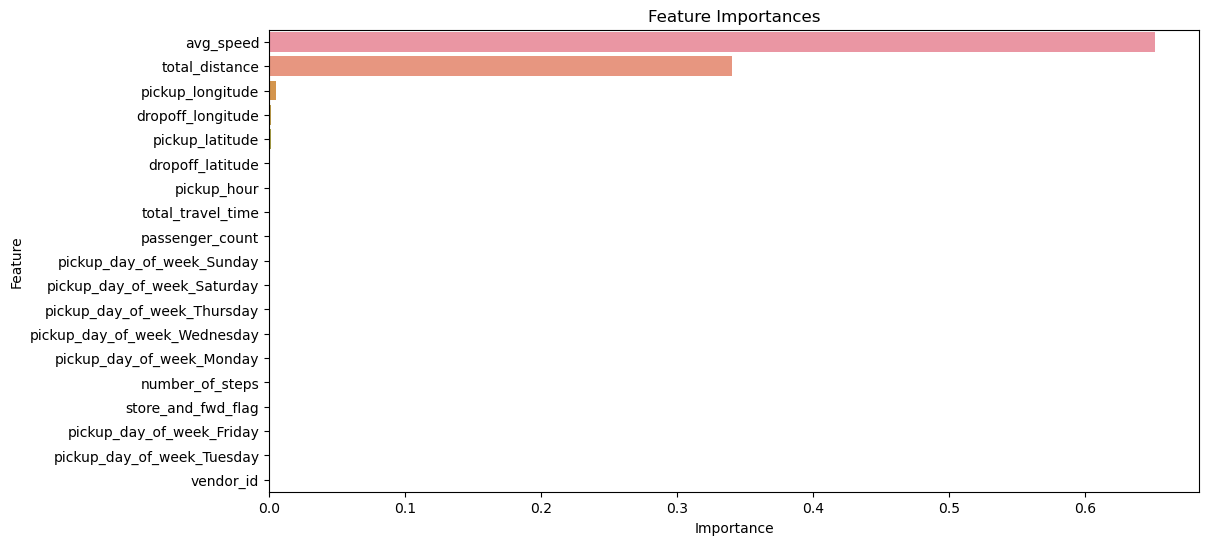

In [92]:
feature_importances = gb.feature_importances_  # gb - наша обученная модель 
feature_names = X_train.columns  # X_train содержит наши факторы

# Создание DataFrame с коэффициентами значимости каждого фактора
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Сортировка значимости по убыванию
importances_df = importances_df.sort_values('Importance', ascending=False)

# Отображение топ-3 наиболее значимых факторов
top3_features = importances_df.head(3)
print(top3_features)

# Построение столбчатой диаграммы
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Feature Importances')
plt.show()

Тремя наиболее значимыми для предсказания целевого признака (длительности поездки) факторами являются средняя скорость (`avg_speed`), общее расстояние (`total_distance`) и долгота, на которой был включен счетчик (`pickup_longitude`).

### Задание 6.4. (1 балл)
Для лучшей из построенных моделей рассчитайте медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведите в минуты и округлите до десятых.


Лучшей моделью оказалась модель градиентного бустинга над деревьями решений. Рассчитаем для нее медианную абсолютную ошибку (MeAE)

In [93]:
from sklearn.metrics import median_absolute_error

mae = median_absolute_error(y_test, gb_pred_test)
mae

0.014220147665828797

In [94]:
# Перевод из секунд в минуты и округление
print('MAE в минутах: {:.1f}'.format(round(mae/60, 1)))

MAE в минутах: 0.0


### Задание 6.5. (2.5 балла)

Напишите развернутую интерпретацию полученных во всем задании результатов.
* Какая модель лучше? 
* Какие признаки важны? 
* Как вы думаете, почему?

RMSLE для моделей получились следующие:

1. модель линейной регрессии  
RMSLE на тренировочной выборке: 0.53  
RMSLE на тестовой выборке: 0.53  
   
           
2. модель регрессии с L2-регуляризацией   
RMSLE на тренировочной выборке: 0.53   
RMSLE на тестовой выборке: 0.53  
   
         
3. модель дерева решений (DecisionTreeRegressor)  
RMSLE на тренировочной выборке: 0.0  
RMSLE на тестовой выборке: 0.06  
   
          
4. модель случайного леса   
RMSLE на тренировочной выборке: 0.06  
RMSLE на тестовой выборке: 0.06  
   
        
5. модель градиентного бустинга над деревьями решений (GradientBoostingRegressor)  
RMSLE на тренировочной выборке:  0.04  
RMSLE на тестовой выборке:  0.05     

Модель дерева решений и модель градиентного бустинга над деревьями решений получились лучше, чем остальные модели. Модель градиентного бустинга над деревьями решений имеет немного более низкую ошибку прогнозирования на тестовой выборке по сравнению с моделью дерева решений, поэтому можно сказать, что она является лучшей моделью.



Важными признаками являются средняя скорость (avg_speed), общее расстояние (total_distance) и долгота, на которой был включен счетчик (pickup_longitude). Наиболее значимыми признаками для предсказания продолжительности поездки на такси являются средняя скорость и общее расстояние: чем выше средняя скорость, тем быстрее будет поездка и тем меньше будет ее продолжительность;  чем больше расстояние, тем дольше будет длиться поездка. Также важной оказалась долгота, на которой был включен счетчик. Действительно, место, куда пассажир заказывает такси, может быть фактором, влияющим на длительность поездки. Интересно, почему долгота оказалась важна, но широта - нет. Посмотрим на описательных статистки этих признаков:

In [106]:
pd.set_option('display.float_format', '{:.8f}'.format)
taxi_data['pickup_longitude'].describe()

count   1440734.00000000
mean        -73.97355894
std           0.07106073
min        -121.93334198
25%         -73.99188232
50%         -73.98177338
75%         -73.96744537
max         -61.33552933
Name: pickup_longitude, dtype: float64

In [107]:
taxi_data['pickup_latitude'].describe()

count   1440734.00000000
mean         40.75090735
std           0.03280310
min          34.35969543
25%          40.73733139
50%          40.75407028
75%          40.76832581
max          51.88108444
Name: pickup_latitude, dtype: float64

Значения долготы находятся в диапазоне от -121.93 до -61.34 с наиболее частыми значениями около -74. В то время как данные по широте имеют немного меньшее стандартное отклонение и находятся в более узком диапазоне значений (от 34.36 до 51.88). Данные о широте не так сильно варьируются, и их значимость для предсказания продолжительности поездки может быть меньшей в сравнении с данными о долготе.

Таким образом, эти признаки являются ключевыми для предсказания продолжительности поездки на такси, так как имеют прямую связь с временем и расстоянием перемещения, что влияет на общую продолжительность поездки.